# IMPORTAMOS LAS LIBRERIAS QUE VAMOS A UTILIZAR

In [1]:
#Ejecuta esta celda para importar las librerias
import pandas as pd
import numpy as np
import scipy.integrate as integ
import threading

import matplotlib.pyplot as plt
import time
from acciones import guardar_csv
from acciones import neutralidad

# Introducción de los datos del modelo

In [9]:
#Ejecuta esta celda para introducir los datos

DatosEntrada=pd.read_excel('datos/datostld100.xlsx', sheet_name='Hoja1', header=0, usecols=None, nrows=None)

dfnew=DatosEntrada

E = dfnew.iloc[:, 0].to_numpy()         # Energia de Activación (eV).
s = dfnew.iloc[:, 1].to_numpy()          # Factor de Frecuencia (s-1).
# Concentracion de electrones atrapados en las trampas (cm-3).
n = dfnew.iloc[:, 2].to_numpy()
# Numero de posiciones acesibles por los electrnes de la BC a la Trampa (cm-3).
N = dfnew.iloc[:, 3].to_numpy()
# Numero de posiciones acesibles por los electrones alcanzada la saturación (cm-3).
Nsat = dfnew.iloc[:, 4].to_numpy()
# Coeficiente de Probabilidad de atrapamiento de electrones de a trampa (cm+3·s-1).
A = dfnew.iloc[:, 5].to_numpy()
# Coeficiente de probabilidad de recombinacion e-h Radiativa (cm+3·s-1).
Amn_R = dfnew.iloc[0:1, 6].to_numpy()
# Coeficiente de probabilidad de recombinacion e-h No Radiativa (cm+3·s-1).
Amn_NR = dfnew.iloc[0:1, 7].to_numpy()
# Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion Radiativo (cm+3·s-1).
A_R = dfnew.iloc[0:1, 8].to_numpy()
# Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion No Radiativo (cm+3·s-1).
A_NR = dfnew.iloc[0:1, 9].to_numpy()
# Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion Radiativo (cm-3).
M_R = dfnew.iloc[0:1, 10].to_numpy()
# Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion No Radiativo (cm-3).
M_NR = dfnew.iloc[0:1, 11].to_numpy()
# Concentracion de h atrapados en el centro de recombonacion radiativo (cm-3).
m_R = dfnew.iloc[0:1, 12].to_numpy()
# Concentracion de h atrapados en el centro de recombonacion no radiativo (cm-3).
M_NR = dfnew.iloc[0:1, 13].to_numpy()
# Factor de generacion de pares e-h (cm-3·s-1).
f = dfnew.iloc[0:1, 14].to_numpy()
# Concentración de electrones libres en la banda de conduccion (cm-3).
n_c = dfnew.iloc[0:1, 15].to_numpy()
# Concentración de huecos libres en la banda de Valencia (cm-3).
n_h = dfnew.iloc[0:1, 16].to_numpy()
# Nivel de Fermi (Ev)
Ef = dfnew.iloc[0:1, 17]
Ef = float(Ef)

#Condiciones iniciales
nn=np.array(n_c[0])
for i in range(len(n)):
    nn=np.append(nn,n[i])
nn=np.append(nn,m_R[0])
nn=np.append(nn,m_NR[0])
nn=np.append(nn,n_h[0])

#Constante de boltzman
kb=0.00008617333262


In [25]:
dfnew.head()

,E (eV),s (s-1),n(cm-3),Nn(cm-3),Nsat(cm-3),A(cm+3·s-1),RAmn(cm+3·s-1),NRAmn(cm+3·s-1),RAh(cm+3·s-1),NRAh(cm+3·s-1),RM(cm-3),NRM(cm-3),Rm(cm-3),NRm(cm-3),f(cm-3·s-1),nc(cm-3),nvcm-3),Ef
0,1.708133,5.298385e+20,0,10000000000,25000000000000,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-11,1.000000e-11,1.000000e+09,1.000000e+09,0.0,0.0,10000000.0,0.0,0.0,2.7
1,1.565926,3.200997e+17,0,10000000000,10000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.642103,2.709883e+17,0,10000000000,5000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.129357,4.537204e+21,0,10000000000,5000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.500000,1.000000e+12,0,10000000000,65000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Definición de las funciones del modelo

In [22]:
#Ejecuta esta celda para definir las funciones del modelo

Nsat = np.ones(len(N))*10**11
# N[3]=N[3]/2
# N[4]=3*N[4]/4
if len(N) == 5:
    Nsat[0] = Nsat[0]*25
    Nsat[1] = Nsat[1]*10
    Nsat[2] = Nsat[2]*5
    Nsat[3] = Nsat[3]*5
    Nsat[4] = Nsat[4]*65


def Ng(t, i):  # En esta función simulamos la creación de trampas durante la irradiación
    C = 1
    return N[i] * np.exp(np.log10(Nsat[i] / N[i]) * (1 - np.exp(-C * t)))


def Nee(E, i, T):  # Esta es la distribución de Fermi-Dirac que utilizaremos en la irradiación
    return N[i] / (1 + np.exp((E - Ef) / (kb * T)))


def NFCT(E, i, T, t):  # Aquí simulamos la creación de trampas durante la irradiación, utilizando también la distribución de Fermi-Dirac
    return Nee(E, i, T) * Ng(t, i) / N[i]


NN = N


def Ne(E, i, T):  # Aquí definimos la distribución de Fermi-Dirac
    # para utilizarla utilizando el numero de trampas disponibles tras la irradiación
    return NN[i] / (1 + np.exp((E - 2.7) / (kb * T)))


Tamb = 273.15


def TLIN(t, u):  # Con esta función simulamos la irradiación añadiendo la creación de trampas,
    # utilizando la función de arrenius para la probabilidad
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (Ng(t, i - 1) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLINE(t, u):  # Aquí simulamos la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))) + \
            A[i - 1] * (NFCT(E[i - 1], i - 1, Tamb, t) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLRNE(t, u):  # Simulamos la relajación tras la irradiación (reduciendo la fuente de radiación en un factor 1000) partiendo de las concentraciones y
    # el número de trampas tras la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D  Nota: revisar que esté bien implementado
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLI(t, u):  # Simulación de la irradiación sin tener en cuenta la creación de trampas usando la ley de arrenius
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLR(t, u):  # Simulación de la relajación de la función anterior
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLE(t, u, beta):  # Simulación del calentamiento
    Tamb = 297.15 + float(t) * beta
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        if u[i] > 10:
            dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                             ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
            Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)

def TLE(t,u,beta):      #Simulación del calentamiento
        Tamb=297.15+float(t)*beta
        kb=0.00008617333262
        dx=np.zeros(len(nn))
        Constante_A=0.0
        for i in range(1,len(dx)-3):
                if u[i]>10:
                        dx[i]=-u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb)))+A[i-1]*(NN[i-1]-u[i])*u[0]
                        Constante_A+=dx[i]
        dx[0]=f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
        dx[-3]=A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
        dx[-2]=A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
        dx[-1]=f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
        return np.array(dx,dtype=object)

def CT(t):
    return 297.15 + float(t) * 10


def TLECT(t, u):  # Simulación del calentamiento utilizando una curva de temperaturas
    # a elección (CT(t))
    Tamb = CT(t)
    kb = 0.00008617333262
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        if u[i] > 10:
            dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))
                           )+A[i-1]*(NN[i-1]-u[i])*u[0]
            Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def tl(X, T, beta):  # Calculamos la curva de termoluminiscencia
    Temp = np.zeros(len(T))
    TL = np.zeros(len(T))
    for i in range(len(T)):
        Temp[i] = T[i]*beta+297.15-273.15
        TL[i] = A_R*X[0, i]*X[-3, i]/beta
    return Temp, TL


def tl200(X, T, beta):  # Guardamos 200 canales de la curva de termoluminiscencia
    Temp, TL = tl(X, T, beta)
    ti200 = np.linspace(T[0], T[-1], 200)
    t200 = np.linspace(Temp[0], Temp[-1], 200)
    tl200 = np.interp(t200, Temp, TL)
    return t200, tl200, ti200


def g200(X, T):
    x = np.zeros((200, len(X[0])), dtype=X.dtype)
    t = np.linspace(T[0], T[-1], 200)
    for i in range(len(X[1])):
        x[:, i] = np.interp(t, T, X[:, i])
    return (x, t)


# Iniziamos la variable que albergará el nuevo número de trampas
NN = np.zeros(len(N))

# Resolución del modelo

error neutralidad:1.0132789611816406e-06


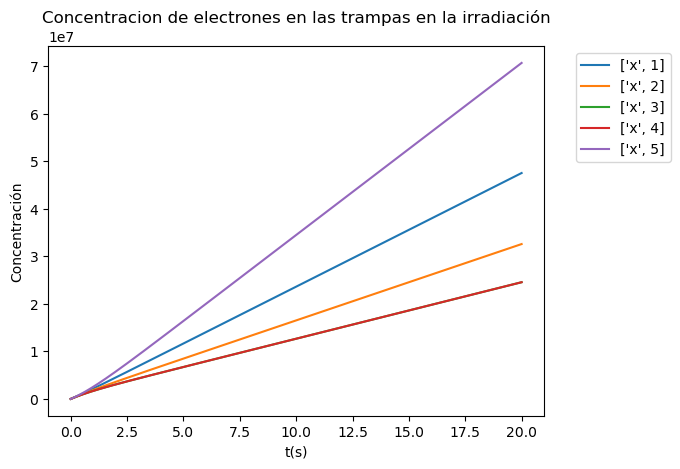

error neutralidad:2.9206275939941406e-06


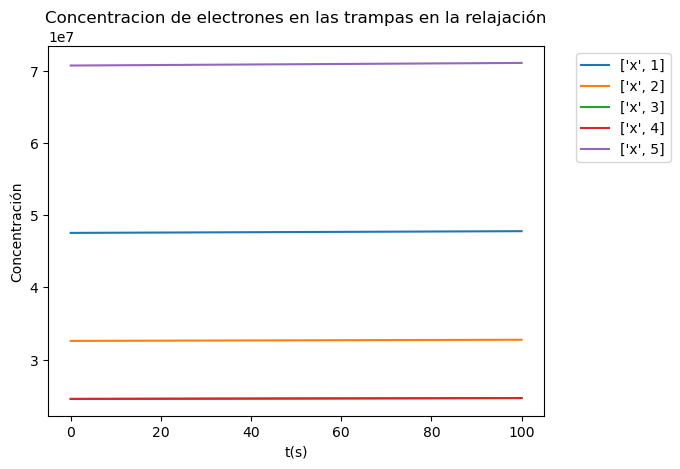

In [20]:
#En esta celda simulamos la irradiación y la relajación


NN=np.zeros(len(N))  #Iniziamos la variable que albergará el nuevo número de trampas
tmax=20                 #tiempo de irradiación
solirrad=integ.solve_ivp(fun=TLINE,t_span=[0,tmax],y0=nn)    #Resolvemos el modelo para la irradiación utilizando 'TLINE'
for i in range(len(N)):
    NN[i]=NFCT(E[i],i,297.15,tmax)       #aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
ti=solirrad.t    #Guardamos el tiempo de la solución en ti
xi=solirrad.y    #Guardamos las concentraciones de la solución en xi

pi=neutralidad(xi) #comprobamos si se cumple la neutralidad de carga
print('error neutralidad:'+str(np.abs(pi.max())))


for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la irradiación
    plt.plot(ti,xi[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Concentracion de electrones en las trampas en la irradiación')
plt.xlabel('t(s)')
plt.ylabel('Concentración')
plt.show()

solrel=integ.solve_ivp(fun=TLRNE,t_span=[0,100],y0=xi[:,-1])   #Resolvemos el modelo para la irradiación con los datos obtenidos en la irradiación
tr=solrel.t
xr=solrel.y

pr=neutralidad(xr) #comprobamos si se cumple la neutralidad de carga
print('error neutralidad:'+str(np.abs(pr).max()))

for i in range(1,len(nn)-3):     #Representamos la concentración en las trampas en la relajación
    plt.plot(tr,xr[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Concentracion de electrones en las trampas en la relajación')
plt.xlabel('t(s)')
plt.ylabel('Concentración')
plt.show()


error neutralidad:2.2649765014648438e-06


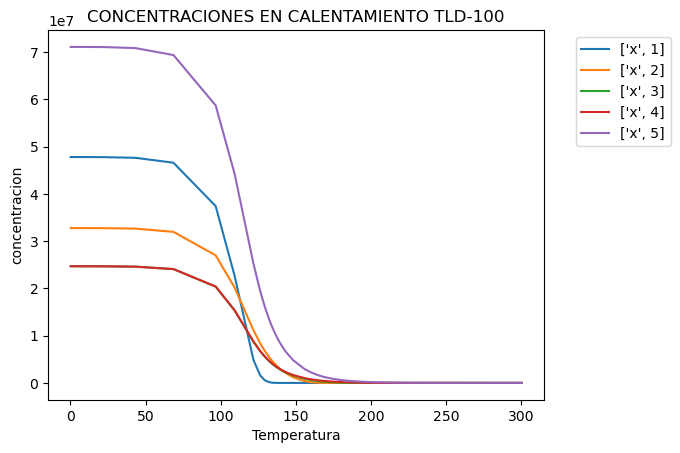

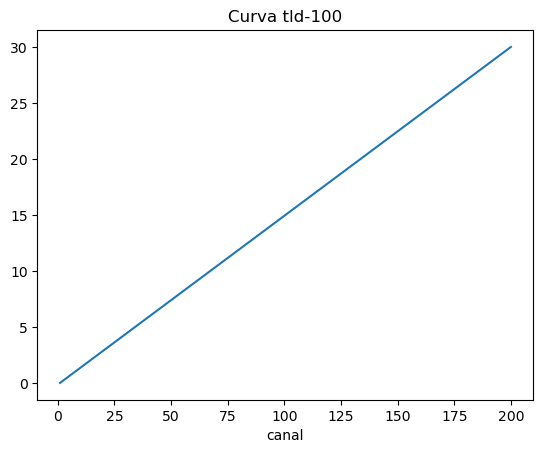

In [23]:
#En esta celda simulamos el calentamiento con una curva de temperaturas lineal

beta=10    #Este parámetro es la pendiente de la curva de calentamiento
mt=((300+273.15)-Tamb)/beta         #aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
solcal=integ.solve_ivp(fun=TLE,t_span=[0,mt],y0=xr[:,-1],args=[beta])       #Resolvemos el modelo para el calentamiento usando 'TLE'
tt=solcal.t     #Guardamos el tiempo de la solución en 'tt'
xx=solcal.y     #Guardamos las concentraciones de la solución en 'xx'
TT=Tamb+beta*tt-273 #Aquí guardamos a qué temperatura corresponde cada instante de tiempo para representar la curva

pi=neutralidad(xx) #comprobamos si se cumple la neutralidad de carga
print('error neutralidad:'+str(np.abs(pi).max()))

for i in range(1,len(nn)-3):        #Representamos las concentraciones de electrones en las trampas durante el calentamiento
    plt.plot(TT,xx[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')    
plt.title('CONCENTRACIONES EN CALENTAMIENTO TLD-100')
plt.xlabel('Temperatura')
plt.ylabel('concentracion')
plt.show()

_, temp,tlc=tl200(xx,tt,beta)          #Simulamos la curva de termoluminiscencia en función de la simulación del calentamiento

canal=np.linspace(1,200,200)        #Representamos la curva de termoluminiscencia
plt.plot(canal,tlc)
plt.title('Curva tld-100')
plt.xlabel('canal')
plt.show()


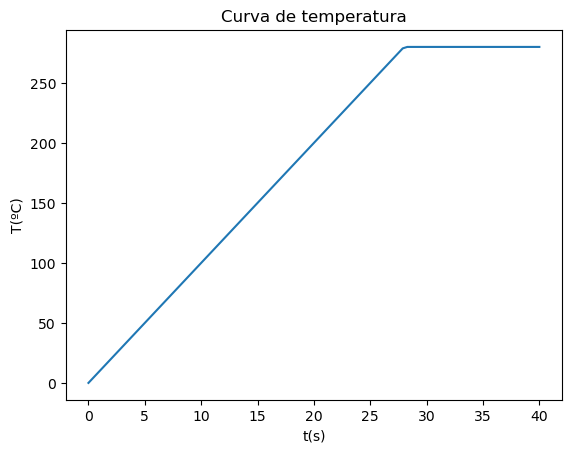

No se conserva la neutralidad de carga en el calentamiento


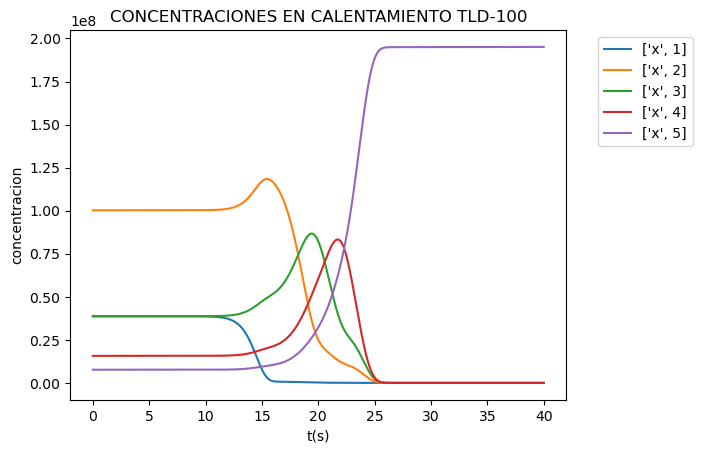

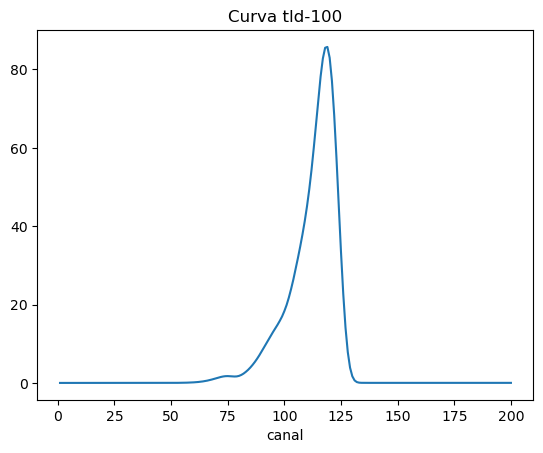

In [6]:
#En esta celda simulamos el calentamiento utilizando una curva de calentamiento que podemos definir

def CT(t):      #En esta función definimos la curva de calentamiento
    maxt=280
    beta=10
    Tamb = 273.15
    if (beta*t+Tamb-273.15)<maxt:   #En este ejemplo hemos definido una rampa hasta los 250 grados seguido 
        T=Tamb+beta*t               #de un tiempo a temperatura constante
        tt=t
    else:
        T=maxt+273.15
    return(T)
t=np.linspace(0,40,100)     #En este vector incluimos el tiempo de calentamiento
T=np.zeros(len(t))          #Iniciamos un vector con las temperaturas
for i in range(len(t)):     #En este bucle llenamos el vector de temperaturas con nuestra curva de temperaturas
    T[i]=CT(t[i])

plt.plot(t,T-273.15)        #Representamos la curva de temperaturas
plt.title('Curva de temperatura')
plt.xlabel('t(s)')
plt.ylabel('T(ºC)')
plt.show()

mt=t[-1]   #Tiempo maximo de calentamiento
solcal=integ.solve_ivp(fun=TLECT,t_span=[0,mt],y0=xr[:,-1]) #Resolvemos el modelo para el calentamiento con nuestra curva de temperaturas
ttt=solcal.t
xxx=solcal.y
TTT=np.zeros(len(ttt)) #Aquí guardamos a qué temperatura corresponde cada instante de tiempo para representar la curva
for i in range(len(ttt)):     #En este bucle llenamos el vector de temperaturas con nuestra curva de temperaturas
    TTT[i]=CT(ttt[i])

pi=neutralidad(xx) #comprobamos si se cumple la neutralidad de carga
if pi.all() > 0.0001:
    print('No se conserva la neutralidad de carga en el calentamiento')
else:
    print('Se conserva la neutralidad de carga en el calentamiento')

for i in range(1,len(nn)-3):        #Representamos las concentraciones de electrones en las trampas durante el calentamiento
    plt.plot(ttt,xxx[i],label=['x',i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')    
plt.title('CONCENTRACIONES EN CALENTAMIENTO TLD-100')
plt.xlabel('t(s)')
plt.ylabel('concentracion')
plt.show()

temp,tlc=tl200(xxx,ttt,10)          #Simulamos la curva de termoluminiscencia en función de la simulación del calentamiento,
                                    #Nota: he puesto beta como '10' para usar la misma función que para el calentamiento lineal, pero no se que se suele usar

canal=np.linspace(1,200,200)        #Representamos la curva de termoluminiscencia
plt.plot(canal,tlc)
plt.title('Curva tld-100')
plt.xlabel('canal')
plt.show()